## Chlorophyll

In [1]:
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import pandas as pd
import statsmodels.api as sm
import xarray as xr

In [13]:
N2Chl = 2

In [2]:
foramt = "{:.2}"
myformat = {'bias': foramt, 'rmse': foramt, 'swillmott': foramt, 'slopedev': foramt, 'const': foramt,
                         'systematic': foramt, 'nonsystematic':foramt, 
                    'spread': foramt}

In [3]:
with xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask201702.nc') as mesh:
    deptht = mesh.gdept_1d[0].values

In [4]:
def bias(df, obs, mod):
    diffy = df[mod] - df[obs]
    return diffy.count(), diffy.mean()

In [5]:
def rmse(df, obs, mod):
    return (np.sqrt(((df[mod] - df[obs])**2).mean()))

In [6]:
def swillmott(df, obs, mod):
    meanobs = df[obs].mean()
    return (((df[mod] - df[obs])**2).sum()
            /(( (df[mod] - meanobs).abs() + (df[obs] - meanobs).abs() )**2).sum())

In [7]:
def slope_inter(df, obs, mod):
    X = df[obs]
    y = df[mod]
    X = sm.add_constant(X)

    # Fit and make the predictions by the model
    model = sm.OLS(y, X, missing='drop').fit()
    predictions = model.predict(X)
    
    nonsyst = np.sqrt(((y - predictions)**2).mean())
    systematic = np.sqrt(((predictions - df[obs])**2).mean())
    return model.params[obs], model.params['const'], systematic, nonsyst

In [8]:
def spread(df, obs, mod):
    return 1 - ((df[mod] - df[mod].mean())**2).mean() / ((df[obs] - df[obs].mean())**2).mean() 

In [9]:
def read_pieces(pieces):
    temp1 = pd.read_csv(pieces[0])
    for piece in pieces[1:]:
        nextpiece = pd.read_csv(piece)
        temp1 = pd.concat([temp1, nextpiece], ignore_index=True)
    return temp1

In [44]:
def plot_and_stats(temp1, name, obs, mod, idepth, jdepth):
    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    vmax = np.log10(50)
    vmin = -2
    print (deptht[idepth], deptht[jdepth])
    counts, xedges, yedges, color = ax.hist2d(temp1[obs][(temp1.k >= idepth) & (temp1.k <= jdepth)], 
                                              temp1[mod][(temp1.k >= idepth) & (temp1.k <= jdepth)], 
                                           bins=np.arange(vmin, vmax, 0.1), norm=LogNorm());
    fig.colorbar(color)
    number, tbias = bias(temp1[(temp1.k >= idepth) & (temp1.k <= jdepth)], obs, mod)
    trmse = rmse(temp1[(temp1.k >= idepth) & (temp1.k <= jdepth)], obs, mod)
    tswillmott = swillmott(temp1[temp1.k >=idepth], obs, mod)
    m, c, syst, nonsyst = slope_inter(temp1[(temp1.k >= idepth) & (temp1.k <= jdepth)], obs, mod)
    tspread = spread(temp1[temp1.k >= idepth], obs, mod)
    ax.plot([vmin, vmax], [vmin, vmax], 'w-');
    xr = np.arange(vmin, vmax, 0.5)
    ax.plot(xr, c + m * xr, 'r-');
    sc = 0.25
    sh = 0.5
    bot = 0.5
    top = bot + 2*sh 
    ax.arrow(-1.9, bot, 0, sh-tbias/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    ax.arrow(-1.9, top, 0, -sh+tbias/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    ax.arrow(-1.7, bot, 0, sh-syst/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    ax.arrow(-1.7, top, 0, -sh+syst/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    ax.arrow(-1.5, bot, 0, sh-nonsyst/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    ax.arrow(-1.5, top, 0, -sh+nonsyst/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True);
    Cp2 = {'number': number,
            'bias': tbias,
          'rmse': trmse,
          'swillmott': tswillmott,
          'slopedev': 1-m,
          'const': c,
          'systematic': syst,
          'nonsystematic': nonsyst,
          'spread': tspread}
    ax.text(-1.9-0.05, 0, 'bias', rotation=90)
    ax.text(-1.7-0.05, -0.3, 'systematic', rotation=90)
    ax.text(-1.5-0.05, -0.5, 'non-systematic', rotation=90)
    ax.set_title(f'{name}, Log Chlorophyll');
    dCp2 = pd.DataFrame(data=Cp2, index=[name])
    return dCp2


In [72]:
pieces = ('/home/sallen/202007/H201812/ObsModel_201812_Bio_20150101-20151231.csv',
         '/home/sallen/202007/H201812/ObsModel_201812_Bio_20160101-20161231.csv',
         '/home/sallen/202007/H201812/ObsModel_201812_Bio_20170101-20171231.csv',
         '/home/sallen/202007/H201812/ObsModel_201812_PSF_20150101-20151231.csv',
         '/home/sallen/202007/H201812/ObsModel_201812_PSF_20160101-20161231.csv',
         '/home/sallen/202007/H201812/ObsModel_201812_PSF_20170101-20171231.csv',
         '/home/sallen/202007/H201812/ObsModel_H201812_pug_20150101_20151231.csv',
         '/home/sallen/202007/H201812/ObsModel_H201812_pug_20160101_20161231.csv',
         '/home/sallen/202007/H201812/ObsModel_H201812_pug_20170101_20171231.csv',
         '/home/sallen/202007/H201812/ObsModel_H201812_hplc_20150101_20151231.csv',
         '/home/sallen/202007/H201812/ObsModel_H201812_hplc_20160101_20161231.csv',
         '/home/sallen/202007/H201812/ObsModel_H201812_hplc_20170101_20171231.csv')

In [12]:
temp1 = read_pieces(pieces)
temp1.keys()

Index(['Unnamed: 0', 'Year', 'Month', 'Day', 'Hour', 'Lat', 'Lon', 'Pressure',
       'Depth', 'Ammonium', 'Ammonium_units', 'Chlorophyll_Extracted',
       'Chlorophyll_Extracted_units', 'N', 'Si', 'Silicate_units', 'AbsSal',
       'ConsT', 'Z', 'dtUTC', 'j', 'i', 'mod_nitrate', 'mod_silicon',
       'mod_ammonium', 'mod_diatoms', 'mod_ciliates', 'mod_flagellates',
       'mod_vosaline', 'mod_votemper', 'k', 'NO23', 'PO4', 'Station', 'Chl',
       'Depth_m', 'Phaeo', 'SA', 'CT', 'pLat', 'pLon', 'tdiffH', 'Basin',
       'Amm', 'p', 'Sample_Number', 'Diatoms-1', 'Diatoms-2', 'Prasinophytes',
       'Cryptophytes', 'Dinoflagellates', 'Haptophytes', 'Dictyochophytes',
       'Raphidophytes', 'Cyanobacteria', 'TchlA (ug/L)',
       'Chlorophyll:Extracted [mg/m^3]', 'Nitrate_plus_Nitrite [umol/L]',
       'Silicate [umol/L]', 'Fluorescence:URU [mg/m^3]'],
      dtype='object')

0.5000002726327963 441.4661096800038


/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
H201812,1543,0.23,0.6,0.46,0.63,0.41,0.37,0.47,-1.7


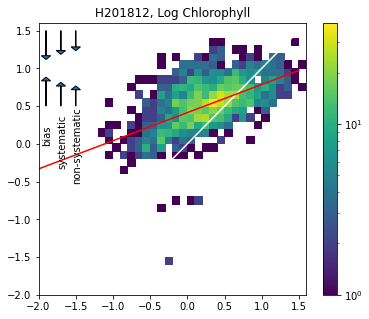

In [73]:
temp1 = read_pieces(pieces)
temp1['Chl'] = temp1.Chl.fillna(value=temp1.Chlorophyll_Extracted).fillna(value=temp1['TchlA (ug/L)']).fillna(value=temp1['Chlorophyll:Extracted [mg/m^3]'])
temp1['mod_chl'] = (temp1.mod_diatoms + temp1.mod_ciliates + temp1.mod_flagellates) * N2Chl
temp1['log_chl'] = np.log10(temp1.Chl)
temp1['log_mod_chl'] = np.log10(temp1.mod_chl)
idepth = 0
jdepth = 39
d201812 = plot_and_stats(temp1, 'H201812', 'log_chl', 'log_mod_chl', idepth, jdepth)
d201812.style.format(myformat)

In [68]:
pieces = ('/home/sallen/202007/H201905/ObsModel_201905_Bio_20150101-20151231.csv',
         '/home/sallen/202007/H201905/ObsModel_201905_Bio_20160101-20161231.csv',
         '/home/sallen/202007/H201905/ObsModel_201905_Bio_20170101-20171231.csv',
         '/home/sallen/202007/H201905/ObsModel_201905_PSF_20150101-20151231.csv',
         '/home/sallen/202007/H201905/ObsModel_201905_PSF_20160101-20161231.csv',
         '/home/sallen/202007/H201905/ObsModel_201905_PSF_20170101-20171231.csv',
         '/home/sallen/202007/H201905/ObsModel_H201905_pug_20150101_20151231.csv',
         '/home/sallen/202007/H201905/ObsModel_H201905_pug_20160101_20161231.csv',
         '/home/sallen/202007/H201905/ObsModel_H201905_pug_20170101_20171231.csv',
         '/home/sallen/202007/H201905/ObsModel_H201905_hplc_20150101_20151231.csv',
         '/home/sallen/202007/H201905/ObsModel_H201905_hplc_20160101_20161231.csv',
         '/home/sallen/202007/H201905/ObsModel_H201905_hplc_20170101_20171231.csv')

0.5000002726327963 441.4661096800038


/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
H201905,1543,-0.072,0.63,0.45,0.56,0.089,0.27,0.57,-2.5


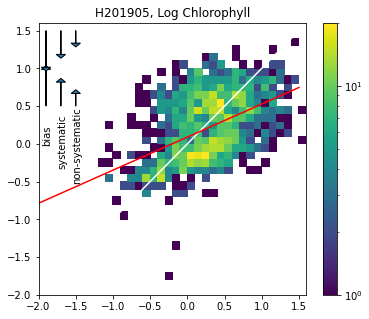

In [69]:
temp1 = read_pieces(pieces)
temp1['Chl'] = temp1.Chl.fillna(value=temp1.Chlorophyll_Extracted).fillna(value=temp1['TchlA (ug/L)']).fillna(value=temp1['Chlorophyll:Extracted [mg/m^3]'])
temp1['mod_chl'] = (temp1.mod_diatoms + temp1.mod_ciliates + temp1.mod_flagellates) * N2Chl
temp1['log_chl'] = np.log10(temp1.Chl)
temp1['log_mod_chl'] = np.log10(temp1.mod_chl)
idepth = 0
jdepth = 39
d201905 = plot_and_stats(temp1, 'H201905', 'log_chl', 'log_mod_chl', idepth, jdepth)
d201905.style.format(myformat)

In [65]:
pieces = ('/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_Bio_20150101-20151231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_Bio_20160101-20161231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_Bio_20170101-20171231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_PSF_20150101-20151231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_PSF_20160101-20161231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_PSF_20170101-20171231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_PUG_20150101-20151231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_PUG_20160101-20161231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_PUG_20170101-20171231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_hplc_20150101_20151231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_hplc_20160101_20161231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_hplc_20170101_20171231.csv')

0.5000002726327963 441.4661096800038


/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
Cp2,1543,0.16,0.57,0.42,0.58,0.32,0.31,0.48,-2.1


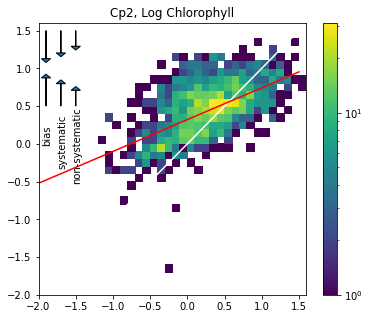

In [66]:
temp1 = read_pieces(pieces)
temp1['Chl'] = temp1.Chl.fillna(value=temp1.Chlorophyll_Extracted).fillna(value=temp1['TchlA (ug/L)']).fillna(value=temp1['Chlorophyll:Extracted [mg/m^3]'])
temp1['mod_chl'] = (temp1.mod_diatoms + temp1.mod_ciliates + temp1.mod_flagellates) * N2Chl
temp1['log_chl'] = np.log10(temp1.Chl)
temp1['log_mod_chl'] = np.log10(temp1.mod_chl)
idepth = 0
jdepth = 39
dCp2 = plot_and_stats(temp1, 'Cp2', 'log_chl', 'log_mod_chl', idepth, jdepth)
dCp2.style.format(myformat)

In [63]:
pieces = ('/home/sallen/202007/202007D-again/ObsModel_202007D-again_Bio_20150101-20151231.csv',
         '/home/sallen/202007/202007D-again/ObsModel_202007D-again_Bio_20160101-20161231.csv',
         '/home/sallen/202007/202007D-again/ObsModel_202007D-again_Bio_20170101-20171231.csv',
         '/home/sallen/202007/202007D-again/ObsModel_202007D-again_PSF_20150101-20151231.csv',
         '/home/sallen/202007/202007D-again/ObsModel_202007D-again_PSF_20160101-20161231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_PSF_20170101-20171231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_pug_20150101_20151231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_pug_20160101_20161231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_pug_20170101_20171231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_hplc_20150101_20151231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_hplc_20160101_20161231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_hplc_20170101_20171231.csv'
        )

0.5000002726327963 441.4661096800038


/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
D-again,1543,-0.021,0.55,0.44,0.62,0.16,0.28,0.47,-2.2


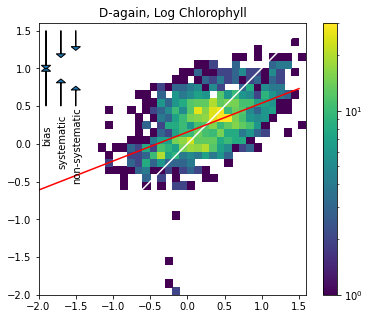

In [64]:
temp1 = read_pieces(pieces)
temp1['Chl'] = temp1.Chl.fillna(value=temp1.Chlorophyll_Extracted).fillna(value=temp1['TchlA (ug/L)']).fillna(value=temp1['Chlorophyll:Extracted [mg/m^3]'])
temp1['mod_chl'] = (temp1.mod_diatoms + temp1.mod_ciliates + temp1.mod_flagellates) * N2Chl
temp1['log_chl'] = np.log10(temp1.Chl)
temp1['log_mod_chl'] = np.log10(temp1.mod_chl)
idepth = 0
jdepth = 39
Dagain = plot_and_stats(temp1, 'D-again', 'log_chl', 'log_mod_chl', idepth, jdepth)
Dagain.style.format(myformat)

In [59]:
pieces = ('/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_Bio_20150101-20151231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_bot_20160101_20161231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_bot_20170101_20171231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_PSF_20150101-20151231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_psf_20160101_20161231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_psf_20170101_20171231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_pug_20150101_20151231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_pug_20160101_20161231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_pug_20170101_20171231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_hplc_20150101_20151231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_hplc_20160101_20161231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_hplc_20170101_20171231.csv')

0.5000002726327963 441.4661096800038


/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
D-lowR,1543,0.029,0.55,0.45,0.62,0.21,0.29,0.47,-1.9


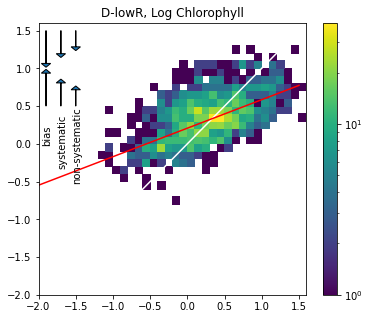

In [61]:
temp1 = read_pieces(pieces)
temp1['Chl'] = temp1.Chl.fillna(value=temp1.Chlorophyll_Extracted).fillna(value=temp1['TchlA (ug/L)']).fillna(value=temp1['Chlorophyll:Extracted [mg/m^3]'])
temp1['mod_chl'] = (temp1.mod_diatoms + temp1.mod_ciliates + temp1.mod_flagellates) * N2Chl
temp1['log_chl'] = np.log10(temp1.Chl)
temp1['log_mod_chl'] = np.log10(temp1.mod_chl)
idepth = 0
jdepth = 39
DlowR = plot_and_stats(temp1, 'D-lowR', 'log_chl', 'log_mod_chl', idepth, jdepth)
DlowR.style.format(myformat)

In [54]:
pieces = ('/home/sallen/202007/202007F/ObsModel_202007F_bot_20150101_20151231.csv',
          '/home/sallen/202007/202007F/ObsModel_202007F_bot_20160101_20161231.csv',
          '/home/sallen/202007/202007F/ObsModel_202007F_bot_20170101_20171231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_psf_20150101_20151231.csv',
          '/home/sallen/202007/202007F/ObsModel_202007F_psf_20160101_20161231.csv',
          '/home/sallen/202007/202007F/ObsModel_202007F_psf_20170101_20171231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_pug_20150101_20151231.csv',
          '/home/sallen/202007/202007F/ObsModel_202007F_pug_20160101_20161231.csv',
          '/home/sallen/202007/202007F/ObsModel_202007F_pug_20170101_20171231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_hplc_20150101_20151231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_hplc_20160101_20161231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_hplc_20170101_20171231.csv')

0.5000002726327963 441.4661096800038


/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
F,1543,-0.06,0.57,0.46,0.63,0.12,0.3,0.48,-1.8


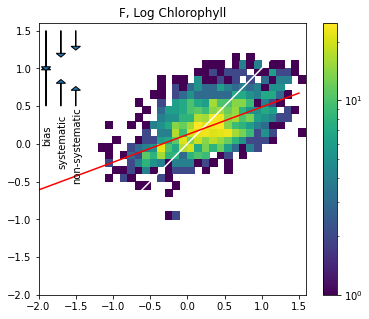

In [58]:
temp1 = read_pieces(pieces)
temp1['Chl'] = temp1.Chl.fillna(value=temp1.Chlorophyll_Extracted).fillna(value=temp1['TchlA (ug/L)']).fillna(value=temp1['Chlorophyll:Extracted [mg/m^3]'])
temp1['mod_chl'] = (temp1.mod_diatoms + temp1.mod_ciliates + temp1.mod_flagellates) * N2Chl
temp1['log_chl'] = np.log10(temp1.Chl)
temp1['log_mod_chl'] = np.log10(temp1.mod_chl)
idepth = 0
jdepth = 39
modF = plot_and_stats(temp1, 'F', 'log_chl', 'log_mod_chl', idepth, jdepth)
modF.style.format(myformat)

In [56]:
def highlight_max_min(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = abs(s) == abs(s).max()
    is_min = abs(s) == abs(s).min()
    color = []
    for v, v2 in zip(is_max, is_min):
        if v:
            color.append('red')
        elif v2:
            color.append('darkgreen')
        else:
            color.append('black')
    return ['color: %s' % color[i] for i in range(len(is_max))]

In [74]:
alltogether = pd.concat([d201812, d201905, dCp2, Dagain, DlowR, modF], axis=0)
foramt = "{:.2}"
alltogether.style.format(myformat).apply(highlight_max_min)

,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
H201812,1543,0.23,0.6,0.46,0.63,0.41,0.37,0.47,-1.7
H201905,1543,-0.072,0.63,0.45,0.56,0.089,0.27,0.57,-2.5
Cp2,1543,0.16,0.57,0.42,0.58,0.32,0.31,0.48,-2.1
D-again,1543,-0.021,0.55,0.44,0.62,0.16,0.28,0.47,-2.2
D-lowR,1543,0.029,0.55,0.45,0.62,0.21,0.29,0.47,-1.9
F,1543,-0.06,0.57,0.46,0.63,0.12,0.3,0.48,-1.8


**Conclusion** All of the "new" runs are pretty similar and are better than either H201812 or H201905.  lowR is a bit better than F, perhaps because F has no ciliates.